In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

import pandas as pd

tf.get_logger().setLevel('ERROR')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
RANDOM_STATE = 44
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 44

In [ ]:
tweets_df = pd.read_csv('data/train.csv', index_col='id')

In [ ]:
tweets_df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
tweet_data = tweets_df.pop('text')
target = tweets_df.pop('target')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(tweet_data, target, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
raw_dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [ ]:
raw_dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
for feat, targ in raw_dataset_train.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b'Japan Heat Wave Intensifies \xc2\x89\xc3\x9b\xc3\x92 Death Toll Surges To 55  http://t.co/irpSSresRq', Target: 1
Features: b'@Bang_Me_Up_Guk he was ;-; like he was singing so loud ;-;', Target: 0
Features: b'@MarianKeyes Rubber Mudslide! Still laughing!', Target: 0
Features: b'Armageddon https://t.co/uCSUDk3q1d', Target: 1
Features: b'Beyond all bounds; till inundation rise', Target: 0


In [ ]:
len(raw_dataset_train), len(raw_dataset_val)

(6090, 1523)

In [ ]:
dataset_train = raw_dataset_train.shuffle(len(raw_dataset_train)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
dataset_val = raw_dataset_val.shuffle(len(raw_dataset_val)).batch(batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
type(raw_dataset_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [ ]:
for text_batch, label_batch in dataset_train.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({label == 1})')

Review: b'@alexbelloli well now I know lol'
Label : 0 (False)
Review: b'Cyclist who collided with runner on Roanoke greenway wins $300000 civil verdict - Roanoke Times: Cyclist who c... http://t.co/E2WfGp8JHk'
Label : 1 (True)
Review: b"Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv"
Label : 1 (True)


In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_preprocess_model

In [ ]:
text_test = ['OMG Horrible Accident Man Died in Wings of Airplane. http://t.co/xDxDPrcPnS. I am so scared.', 'this is not good']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [  101 18168  2290  9202  4926  2158  2351  1999  4777  1997 13297  1012]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(2, 512)
Pooled Outputs Values:[ 0.92482185  0.99832433 -0.11968634  0.13600925 -0.36520037  0.9323524
  0.996665   -0.99025947  0.2794104  -0.99579835 -0.02256511 -0.99463373]
Sequence Outputs Shape:(2, 128, 512)
Sequence Outputs Values:[[ 0.89010984  0.5363968   0.44512606 ... -0.05968648 -0.42927223
   0.51187754]
 [ 0.8318007   0.75544554  0.9615983  ... -0.32709706  0.22416838
  -1.4370464 ]
 [-1.569192   -0.22528312  0.40620145 ... -0.1104103  -0.4472014
  -0.41547996]
 ...
 [-0.5500458  -0.76538396  0.5824052  ... -0.96294224 -0.13816537
   0.31517476]
 [ 0.59016204 -0.11983693 -0.47520733 ...  0.2547591  -0.08762221
  -0.02219772]
 [ 0.8945192   0.67119956 -0.60911894 ...  0.02662407  0.11308891
   0.39829522]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.7392881]
 [0.7696662]], shape=(2, 1), dtype=float32)


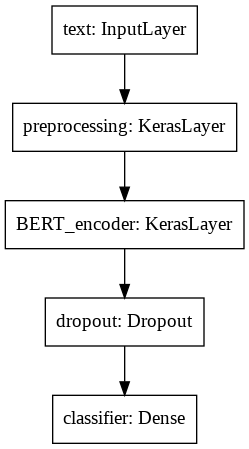

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(dataset_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=dataset_train,
                               validation_data=dataset_val,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
191/191 [==============================] - 1231s 6s/step - loss: 0.6418 - binary_accuracy: 0.6376 - val_loss: 0.4007 - val_binary_accuracy: 0.8286
Epoch 2/5
191/191 [==============================] - 1220s 6s/step - loss: 0.4042 - binary_accuracy: 0.8224 - val_loss: 0.3950 - val_binary_accuracy: 0.8319
Epoch 3/5
191/191 [==============================] - 1220s 6s/step - loss: 0.3260 - binary_accuracy: 0.8703 - val_loss: 0.4459 - val_binary_accuracy: 0.8372
Epoch 4/5
191/191 [==============================] - 1223s 6s/step - loss: 0.2769 - binary_accuracy: 0.8882 - val_loss: 0.4089 - val_binary_accuracy: 0.8404
Epoch 5/5
191/191 [==============================] - 1221s 6s/step - loss: 0.2406 - binary_accuracy: 0.9077 - val_loss: 0.4371 - val_binary_accuracy: 0.8424


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'tweet'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
saved_model_path

'./tweet_bert'

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.032112
input: The movie was great!           : score: 0.034636
input: The movie was meh.             : score: 0.053057
input: The movie was okish.           : score: 0.068383
input: The movie was terrible...      : score: 0.056575

Results from the model in memory:
input: this is such an amazing movie! : score: 0.032112
input: The movie was great!           : score: 0.034636
input: The movie was meh.             : score: 0.053057
input: The movie was okish.           : score: 0.068383
input: The movie was terrible...      : score: 0.056575



In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.032112
input: The movie was great!           : score: 0.034636
input: The movie was meh.             : score: 0.053057
input: The movie was okish.           : score: 0.068383
input: The movie was terrible...      : score: 0.056575

